In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# 시드 설정
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
import os

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

Reference: https://www.kaggle.com/code/baranbingl/face-shape-detection-85-acc-on-test-set

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("niten19/face-shape-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-shape-dataset


In [5]:
# 데이터 증강 및 전처리 설정
BATCH_SIZE = 32
IMG_SIZE = 224
TRAIN_PATH = path+'/FaceShape Dataset/training_set'
TEST_PATH =path+'/FaceShape Dataset/testing_set'

In [6]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # EfficientNet에 최적화된 전처리
    horizontal_flip=True,
    rotation_range=10,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    validation_split=0.0  # 별도의 테스트 세트가 있으므로 0으로 설정
)


In [8]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [9]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [10]:
# 클래스 수 확인
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print(f"Classes: {class_indices}")
print(f"Number of classes: {num_classes}")

Classes: {'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}
Number of classes: 5


In [11]:

# EfficientNetB0 기반 모델 생성
def create_model(num_classes):
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # 기본 모델의 가중치를 고정하지 않음 (fine-tuning)
    base_model.trainable = True

    # 모델 구성
    model = keras.Sequential([
        base_model,
        #layers.GlobalAveragePooling2D(),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model(num_classes)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.AdamW(
        learning_rate=5e-3,
        beta_1=0.9,
        beta_2=0.999,
        weight_decay=0.01
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
    metrics=['accuracy']
)

# 모델 구조 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [13]:
# 콜백 설정
callbacks = [
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        filepath='best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

In [14]:
# 모델 훈련
NUM_EPOCHS = 30


history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.3038 - loss: 1.6660
Epoch 1: val_accuracy improved from -inf to 0.20100, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 166s 964ms/step - accuracy: 0.3041 - loss: 1.6651 - val_accuracy: 0.2010 - val_loss: 7.8749 - learning_rate: 0.0050
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.4403 - loss: 1.4155
Epoch 2: val_accuracy improved from 0.20100 to 0.27400, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 688ms/step - accuracy: 0.4405 - loss: 1.4151 - val_accuracy: 0.2740 - val_loss: 3.6645 - learning_rate: 0.0050
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.5272 - loss: 1.2715
Epoch 3: val_accuracy improved from 0.27400 to 0.39600, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 691ms/step - accuracy: 0.5273 - loss: 1.2715 - val_accuracy: 0.3960 - val_loss: 2.0656 - learning_rate: 0.0050
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.5763 - loss: 1.2053
Epoch 4: val_accuracy improved from 0.39600 to 0.48100, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 692ms/step - accuracy: 0.5763 - loss: 1.2053 - val_accuracy: 0.4810 - val_loss: 1.7113 - learning_rate: 0.0050
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.6174 - loss: 1.1294
Epoch 5: val_accuracy improved from 0.48100 to 0.55400, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 688ms/step - accuracy: 0.6175 - loss: 1.1294 - val_accuracy: 0.5540 - val_loss: 1.3477 - learning_rate: 0.0050
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.6423 - loss: 1.0990
Epoch 6: val_accuracy did not improve from 0.55400
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 682ms/step - accuracy: 0.6423 - loss: 1.0989 - val_accuracy: 0.4810 - val_loss: 1.6095 - learning_rate: 0.0050
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.6630 - loss: 1.0516
Epoch 7: val_accuracy did not improve from 0.55400
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 679ms/step - accuracy: 0.6630 - loss: 1.0517 - val_accuracy: 0.5090 - val_loss: 1.5789 - learning_rate: 0.0050
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.6813 - loss: 0.9994
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0004999999888241291.

Epoch 8: val_accuracy did not improve from 0.55400
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 683ms/step - accuracy: 0.6813 - loss: 0.9

125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 688ms/step - accuracy: 0.7523 - loss: 0.8927 - val_accuracy: 0.7310 - val_loss: 0.9067 - learning_rate: 5.0000e-04
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.7994 - loss: 0.7916
Epoch 10: val_accuracy improved from 0.73100 to 0.74400, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 686ms/step - accuracy: 0.7994 - loss: 0.7916 - val_accuracy: 0.7440 - val_loss: 0.8718 - learning_rate: 5.0000e-04
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8188 - loss: 0.7627
Epoch 11: val_accuracy improved from 0.74400 to 0.75700, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 688ms/step - accuracy: 0.8188 - loss: 0.7627 - val_accuracy: 0.7570 - val_loss: 0.8561 - learning_rate: 5.0000e-04
Epoch 12/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8364 - loss: 0.7385
Epoch 12: val_accuracy improved from 0.75700 to 0.77400, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 685ms/step - accuracy: 0.8364 - loss: 0.7386 - val_accuracy: 0.7740 - val_loss: 0.8631 - learning_rate: 5.0000e-04
Epoch 13/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8386 - loss: 0.7203
Epoch 13: val_accuracy did not improve from 0.77400
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 679ms/step - accuracy: 0.8386 - loss: 0.7203 - val_accuracy: 0.7670 - val_loss: 0.8525 - learning_rate: 5.0000e-04
Epoch 14/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8474 - loss: 0.7051
Epoch 14: val_accuracy improved from 0.77400 to 0.78400, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 683ms/step - accuracy: 0.8474 - loss: 0.7052 - val_accuracy: 0.7840 - val_loss: 0.8310 - learning_rate: 5.0000e-04
Epoch 15/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8591 - loss: 0.6787
Epoch 15: val_accuracy did not improve from 0.78400
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 681ms/step - accuracy: 0.8590 - loss: 0.6788 - val_accuracy: 0.7750 - val_loss: 0.8536 - learning_rate: 5.0000e-04
Epoch 16/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8669 - loss: 0.6599
Epoch 16: val_accuracy did not improve from 0.78400
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 683ms/step - accuracy: 0.8669 - loss: 0.6600 - val_accuracy: 0.7830 - val_loss: 0.8306 - learning_rate: 5.0000e-04
Epoch 17/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8763 - loss: 0.6571
Epoch 17: val_accuracy improved from 0.78400 to 0.79900, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 689ms/step - accuracy: 0.8763 - loss: 0.6571 - val_accuracy: 0.7990 - val_loss: 0.8249 - learning_rate: 5.0000e-04
Epoch 18/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8809 - loss: 0.6355
Epoch 18: val_accuracy did not improve from 0.79900
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 683ms/step - accuracy: 0.8809 - loss: 0.6355 - val_accuracy: 0.7790 - val_loss: 0.8636 - learning_rate: 5.0000e-04
Epoch 19/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.8912 - loss: 0.6318
Epoch 19: val_accuracy did not improve from 0.79900
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 681ms/step - accuracy: 0.8912 - loss: 0.6317 - val_accuracy: 0.7970 - val_loss: 0.8391 - learning_rate: 5.0000e-04
Epoch 20/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.8932 - loss: 0.6131
Epoch 20: ReduceLROnPlateau reducing learning rate to 4.9999996554106475e-05.

Epoch 20: val_accuracy did not improve from 0.79900
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 683ms/step - accuracy

125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 690ms/step - accuracy: 0.9094 - loss: 0.5940 - val_accuracy: 0.8080 - val_loss: 0.8271 - learning_rate: 5.0000e-05
Epoch 22/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9084 - loss: 0.5872
Epoch 22: val_accuracy improved from 0.80800 to 0.81100, saving model to best_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 86s 687ms/step - accuracy: 0.9084 - loss: 0.5872 - val_accuracy: 0.8110 - val_loss: 0.8224 - learning_rate: 5.0000e-05
Epoch 23/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9205 - loss: 0.5695
Epoch 23: val_accuracy did not improve from 0.81100
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 680ms/step - accuracy: 0.9205 - loss: 0.5696 - val_accuracy: 0.8060 - val_loss: 0.8228 - learning_rate: 5.0000e-05
Epoch 24/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9245 - loss: 0.5642
Epoch 24: val_accuracy did not improve from 0.81100
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 684ms/step - accuracy: 0.9245 - loss: 0.5642 - val_accuracy: 0.8040 - val_loss: 0.8240 - learning_rate: 5.0000e-05
Epoch 25/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9265 - loss: 0.5562
Epoch 25: ReduceLROnPlateau reducing learning rate to 4.999999509891496e-06.

Epoch 25: val_accuracy did not improve from 0.81100
125/125 ━━━━━━━━━━━━━━━━━━━━ 85s 684ms/step - accuracy:

In [15]:
# 최종 평가
print("\nFinal evaluation on test set:")
model.load_weights('best_model.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")




Final evaluation on test set:
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 220ms/step - accuracy: 0.8105 - loss: 0.8100
Test Loss: 0.8224
Test Accuracy: 0.8110


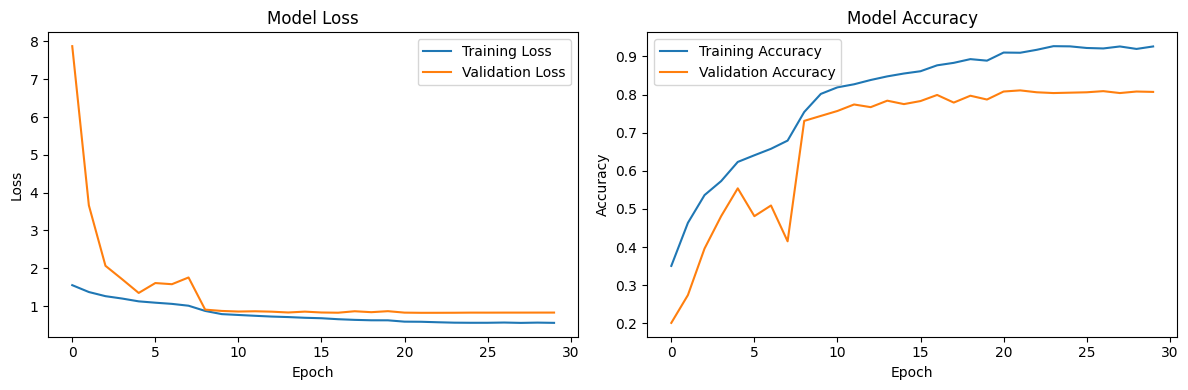

In [16]:
# 훈련 기록 시각화
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 손실 그래프
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # 정확도 그래프
    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)